In [247]:
import pandas as pd
import numpy as np

# Import Regular Expression
import re

# Loading the data
df = pd.read_csv("Data/jumia_phones.csv")

# Display the first few rows of the data to get a sense of the data structure
df.head()

,Name,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,"XIAOMI Redmi A3, 6.71"", 3GB RAM + 64GB (Dual S...","KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,"Tecno Spark 20, Android 13, 6.6"", 128GB + 4GB ...","KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,"Samsung Galaxy A05, 6.7'' 4GB RAM + 128GB ROM ...","KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [248]:
# data = df['Name']

# #convert the data type of data to list 
# data = data.tolist()

# data

Let us define a function to extract the different phone features from the name column

In [249]:
# Column name to work with
product_column = 'Name'

# Function to extract a feature based on regex and rename the column
def extract_feature(df, column, pattern, feature_name):
    def extractor(name):
        match = re.search(pattern, name)
        return match.group(1).strip() if match else None

    return df[column].apply(extractor).rename(feature_name)

# Define regex patterns
patterns = {
    'Brand': r"(?P<brand>[\w\s]+)(?=\+|,\s|\s|$)",
    'Screen Size': r"(?P<screen_size>\d+(\.\d+)?)(?=['\"]{1,2})",
    'RAM': r"\b(?P<RAM>\d\s?GB)\b",
    'ROM': r"\b(?P<ROM>\d{2,}\s?GB)\b",
    'Color': r"[,-]\s*(?P<Color>([A-Z][a-z]+(?:\s[A-Z][a-z]+)*))\s*(?:\+.*)?(?=\s*\(|$)",
    'Warranty': r"(\d+)\s*(?:YR|WRTY)",
    'Camera': r'(\d+MP)',
    'Battery': r'(\d{4}mAh)',
    'Number of SIMs': r'\(?(Dual\s+Sim|DUAL\s+SIM|Single\s+Sim|Single)\)?'
}

# Extract features using the defined patterns
extracted_features = {
    name: extract_feature(df, product_column, pattern, name)
    for name, pattern in patterns.items()
}

# Special handling for Warranty and Number of SIMs
extracted_features['Warranty'] = extracted_features['Warranty'].apply(lambda x: 2 if x == '2' else (1 if x == '1' else 0))
extracted_features['sim_cards'] = extracted_features['Number of SIMs'].apply(lambda x: 2 if x and 'Dual' in x else 1)

# Clean up the Brand column to title case
extracted_features['Brand'] = extracted_features['Brand'].str.lower().str.title()

# Combine all extracted features into a single DataFrame
extracted_features_df = pd.DataFrame(extracted_features)

# Concatenate with the original DataFrame, excluding the product column
final_df = pd.concat([extracted_features_df, df.drop(columns=[product_column])], axis=1)

# Display the final DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [250]:
# Let us clean the Rating column to keep only the result and rename it to Ratings_out_of_5
final_df['Ratings_out_of_5'] = final_df['Rating'].str.extract(r'(\d+\.\d+)')[0]

# Drop the Rating column
final_df.drop(columns=['Rating'], inplace=True)

# Clean the Number of Reviews column to extract the number in parentheses
final_df['Number of Reviews'] = final_df['Number of Reviews'].str.extract(r'\((\d+)\)')[0]

# Define regex pattern to extract page and rank
pattern = r'Page (?P<Page>\d+), Rank (?P<Rank>\d+)'

# Extract page and rank into new columns
final_df[['Page', 'Rank']] = final_df['Search Ranking'].str.extract(pattern)

# Display the cleaned DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Number of Reviews,Search Ranking,Ratings_out_of_5,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,220,"Page 1, Rank 1",4.1,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,135,"Page 1, Rank 2",4.4,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,151,"Page 1, Rank 3",4.2,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,29,"Page 1, Rank 4",4.5,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,249,"Page 1, Rank 5",4.3,1,5


In [251]:
# Filter rows where Camera is NaN
phones_with_nan_camera = final_df[final_df['Camera'].isna()]

# Count the number of unique brands with NaN Camera
phones_with_nan_camera['Brand'].value_counts()

Brand
Xiaomi Redmi 14C       900
Xiaomi Redmi A3        600
Infinix Smart 8        600
Samsung Galaxy A05S    300
Oppo A83 4Gb Ram       300
Oppo A17K              300
Itel A18               300
Name: count, dtype: int64

Let us check the internet and see what the camera specs for these devices are since the list is small. We will ipute these details in the missing values for camera and keep the entries rather than dropping them.

In [252]:
# Dictionary with phone models and their corresponding rear camera megapixels (numeric only) aquired from the internet
camera_specs = {
    "Xiaomi Redmi 14C": 50,  # 50 MP camera
    "Xiaomi Redmi A3": 13,   # 13 MP camera
    "Infinix Smart 8": 13,   # 13 MP camera
    "Samsung Galaxy A05S": 50,  # 50 MP camera
    "Oppo A83 4Gb Ram": 13,   # 13 MP camera
    "Oppo A17K": 50,          # 50 MP camera
    "Itel A18": 5            # 5 MP camera
}

# Function to replace NaN values with the camera specs from the dictionary (numeric only)
def replace_camera_specs(row):
    if pd.isna(row['Camera']) and row['Brand'] in camera_specs:
        return camera_specs[row['Brand']]
    return row['Camera']

# Apply the function to the 'Camera' column
final_df['Camera'] = final_df.apply(replace_camera_specs, axis=1)

# Print the updated DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Number of Reviews,Search Ranking,Ratings_out_of_5,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,13,5000mAh,None,1,"KSh 11,000",NaN,NaN,220,"Page 1, Rank 1",4.1,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,135,"Page 1, Rank 2",4.4,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,151,"Page 1, Rank 3",4.2,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,29,"Page 1, Rank 4",4.5,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,249,"Page 1, Rank 5",4.3,1,5


In [253]:
# Rename Brand to phone_name, Screen Size to display, ROM to storage
final_df.rename(columns={'Brand': 'phone_name', 'Screen Size': 'display', 'ROM': 'storage'}, inplace=True)

# Drop the Search Ranking and Old Price column
final_df.drop(columns=['Search Ranking', 'Old Price', 'Number of SIMs'], inplace=True)

# Change all column names to lowercase and add _ between the parts of the column names
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')

# Display the cleaned DataFrame
final_df['color'].head(100)

# Get the 97th entry in the final_df
final_df.iloc[97]

phone_name            Itel S23
display                    6.6
ram                        8GB
storage                  128GB
color                     None
warranty                     0
camera                    50MP
battery                5000mAh
sim_cards                    1
price                KSh 9,999
discount                   50%
number_of_reviews           41
ratings_out_of_5           4.5
page                         3
rank                        18
Name: 97, dtype: object

In [254]:
# Let us check our modified DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   phone_name         12000 non-null  object
 1   display            11100 non-null  object
 2   ram                12000 non-null  object
 3   storage            12000 non-null  object
 4   color              9600 non-null   object
 5   warranty           12000 non-null  int64 
 6   camera             12000 non-null  object
 7   battery            9300 non-null   object
 8   sim_cards          12000 non-null  int64 
 9   price              12000 non-null  object
 10  discount           8101 non-null   object
 11  number_of_reviews  11700 non-null  object
 12  ratings_out_of_5   10200 non-null  object
 13  page               12000 non-null  object
 14  rank               12000 non-null  object
dtypes: int64(2), object(13)
memory usage: 1.4+ MB


In [255]:
# Check for missing values in the dataframe
final_df.isnull().sum()

phone_name              0
display               900
ram                     0
storage                 0
color                2400
warranty                0
camera                  0
battery              2700
sim_cards               0
price                   0
discount             3899
number_of_reviews     300
ratings_out_of_5     1800
page                    0
rank                    0
dtype: int64

In [256]:
# Convert Screen Size to float
final_df['display'] = final_df['display'].astype(float)
final_df['ratings_out_of_5'] = final_df['ratings_out_of_5'].astype(float)

# Convert RAM and ROM to integer
final_df['ram'] = final_df['ram'].str.replace('GB', '').astype(int)
final_df['storage'] = final_df['storage'].str.replace('GB', '').astype(int)

# Convert Page and Rank to integer
final_df['page'] = final_df['page'].astype(int)
final_df['rank'] = final_df['rank'].astype(int)

# Convert Price and Old Price to float
final_df['price'] = final_df['price'].str.replace(r'[^\d]', '', regex=True).astype(float)

# Convert the Reviews to numbers
final_df['number_of_reviews'] = final_df['number_of_reviews'].fillna(0).astype(float).astype(int)

#View the first 6 rows of the final set
final_df.head()

,phone_name,display,ram,storage,color,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,Midnight Black,2,13,5000mAh,1,11000.0,NaN,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,Gravity Black,1,50MP,5000mAh,1,12925.0,14%,135,4.4,1,2
2,Itel S23,6.60,4,128,Mystery White,1,50MP,5000mAh,1,10000.0,NaN,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,Black,0,50MP,5000mAh,2,14000.0,NaN,29,4.5,1,4
4,Itel S23,6.60,4,128,Starry Black,0,50MP,5000mAh,1,10000.0,NaN,249,4.3,1,5


In [257]:
# Drop the color column
final_df.drop(columns=['color'], inplace=True)

# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from battery entries and handle None values
final_df['battery'] = final_df['battery'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# Remove the % symbol from the discount entries
final_df['discount'] = final_df['discount'].str.replace('%', '')

final_df.head()

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,NaN,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,1,50MP,5000,1,12925.0,14,135,4.4,1,2
2,Itel S23,6.60,4,128,1,50MP,5000,1,10000.0,NaN,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50MP,5000,2,14000.0,NaN,29,4.5,1,4
4,Itel S23,6.60,4,128,0,50MP,5000,1,10000.0,NaN,249,4.3,1,5


In [258]:
# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from camera entries
final_df['camera'] = final_df['camera'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# View the first 10 rows of the final DataFrame to check for any changes in the data structure and values
final_df.head(10)

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,13,5000,1,11000.0,0,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,1,50,5000,1,12925.0,14,135,4.4,1,2
2,Itel S23,6.60,4,128,1,50,5000,1,10000.0,0,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,14000.0,0,29,4.5,1,4
4,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,249,4.3,1,5
5,Samsung Galaxy A15,6.50,4,128,0,50,5000,1,17445.0,42,420,4.2,1,6
6,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,13899.0,40,116,3.9,1,7
7,Xiaomi Redmi 13C,6.74,8,256,0,50,5000,2,16899.0,44,151,NaN,1,8
8,Tecno Spark 20,6.60,8,128,0,50,None,2,14399.0,45,198,4.1,1,9
9,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,111,4.2,1,10


In [259]:
# Get the mode (most frequent value) from the 'battery' column
battery_mode = final_df['battery'].mode()[0]

# Fill missing values in 'Battery' column with the mode value
final_df['battery'] = final_df['battery'].fillna(battery_mode)

# Check the DataFrame info to see if the missing values were filled
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         12000 non-null  object 
 1   display            11100 non-null  float64
 2   ram                12000 non-null  int64  
 3   storage            12000 non-null  int64  
 4   warranty           12000 non-null  int64  
 5   camera             12000 non-null  object 
 6   battery            12000 non-null  object 
 7   sim_cards          12000 non-null  int64  
 8   price              12000 non-null  float64
 9   discount           12000 non-null  object 
 10  number_of_reviews  12000 non-null  int64  
 11  ratings_out_of_5   10200 non-null  float64
 12  page               12000 non-null  int64  
 13  rank               12000 non-null  int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.3+ MB


In [260]:
# Let us drop the None values from the dataframe
final_df = final_df.dropna()

# Display the final DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         9600 non-null   object 
 1   display            9600 non-null   float64
 2   ram                9600 non-null   int64  
 3   storage            9600 non-null   int64  
 4   warranty           9600 non-null   int64  
 5   camera             9600 non-null   object 
 6   battery            9600 non-null   object 
 7   sim_cards          9600 non-null   int64  
 8   price              9600 non-null   float64
 9   discount           9600 non-null   object 
 10  number_of_reviews  9600 non-null   int64  
 11  ratings_out_of_5   9600 non-null   float64
 12  page               9600 non-null   int64  
 13  rank               9600 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 1.1+ MB


In [261]:
# let us convert the battery, camera, and discount entries to integer
final_df['battery'] = final_df['battery'].astype(int)
final_df['camera'] = final_df['camera'].astype(int)
final_df['discount'] = final_df['discount'].astype(int)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9600 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         9600 non-null   object 
 1   display            9600 non-null   float64
 2   ram                9600 non-null   int64  
 3   storage            9600 non-null   int64  
 4   warranty           9600 non-null   int64  
 5   camera             9600 non-null   int64  
 6   battery            9600 non-null   int64  
 7   sim_cards          9600 non-null   int64  
 8   price              9600 non-null   float64
 9   discount           9600 non-null   int64  
 10  number_of_reviews  9600 non-null   int64  
 11  ratings_out_of_5   9600 non-null   float64
 12  page               9600 non-null   int64  
 13  rank               9600 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB


In [262]:
# Select only the numerical columns from the DataFrame
numerical_df = final_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                        display           ram       storage      warranty  \
display            1.000000e+00  3.900424e-01  3.652260e-01  4.499789e-02   
ram                3.900424e-01  1.000000e+00  7.210515e-01 -2.258065e-01   
storage            3.652260e-01  7.210515e-01  1.000000e+00 -2.432996e-01   
warranty           4.499789e-02 -2.258065e-01 -2.432996e-01  1.000000e+00   
camera             3.695617e-01  6.009311e-01  5.905625e-01 -1.598618e-01   
battery            8.052797e-01  5.107561e-01  4.973812e-01  3.283487e-02   
sim_cards          1.591018e-01  2.525301e-01  9.442149e-02  1.493457e-01   
price              3.748688e-01  4.908857e-01  5.981378e-01 -1.446853e-01   
discount           1.661520e-01  4.175975e-01  2.226857e-01 -1.828304e-01   
number_of_reviews -5.359748e-02 -4.098311e-03 -7.231733e-02  2.539275e-01   
ratings_out_of_5   4.144471e-01  1.982043e-01  1.841027e-01 -7.437686e-02   
page               2.580026e-14  1.548786e-15  6.957471e-16 -1.083652e-16   

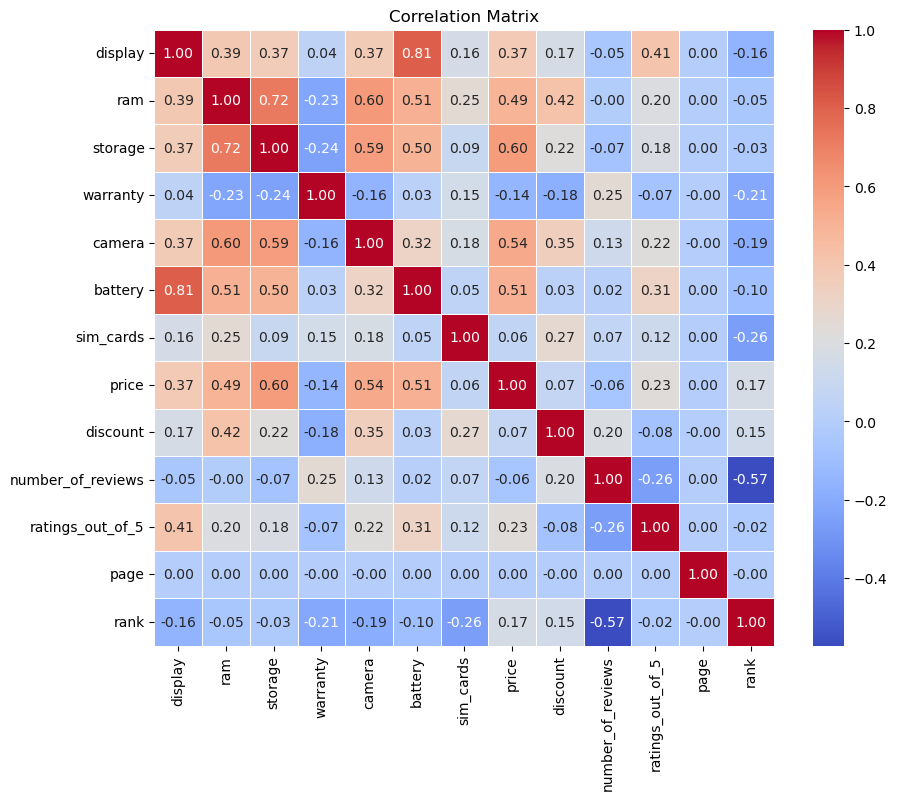

In [263]:
# Let us visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title("Correlation Matrix")
plt.show()

Let us assess the relationships between key product features (like price, ratings, rank, camera, and reviews) using correlation analysis and linear regression. It identifies which factors most influence product ratings, price, and rank. This is useful for understanding how product attributes drive consumer perceptions, pricing strategies, and product positioning in the market. The results can guide decisions on product development, pricing, and marketing efforts.

Correlation with ratings_out_of_5:
ratings_out_of_5     1.000000e+00
display              4.144471e-01
battery              3.146947e-01
price                2.309666e-01
camera               2.213260e-01
ram                  1.982043e-01
storage              1.841027e-01
sim_cards            1.209857e-01
page                 1.413558e-14
rank                -2.403557e-02
warranty            -7.437686e-02
discount            -7.547220e-02
number_of_reviews   -2.587422e-01
Name: ratings_out_of_5, dtype: float64


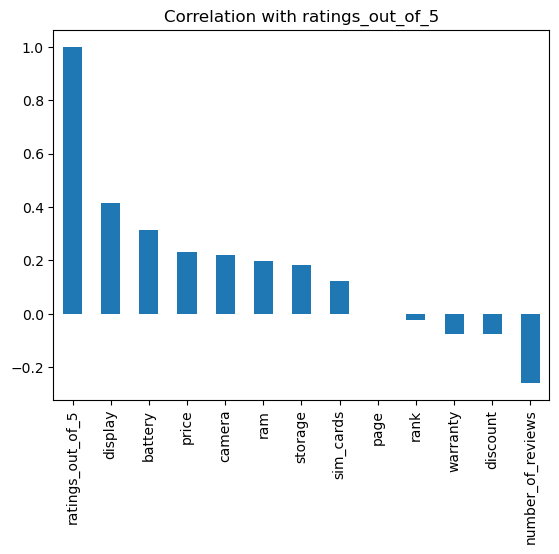

Linear Regression Coefficients for ratings_out_of_5:
             Feature  Coefficient
2                ram     0.004696
1             camera     0.001645
0              price     0.000011
4  number_of_reviews    -0.001243
3               rank    -0.006729
Correlation with price:
price                1.000000
storage              0.598138
camera               0.544404
battery              0.509855
ram                  0.490886
display              0.374869
ratings_out_of_5     0.230967
rank                 0.166535
discount             0.074719
sim_cards            0.063644
page                 0.000082
number_of_reviews   -0.062362
warranty            -0.144685
Name: price, dtype: float64


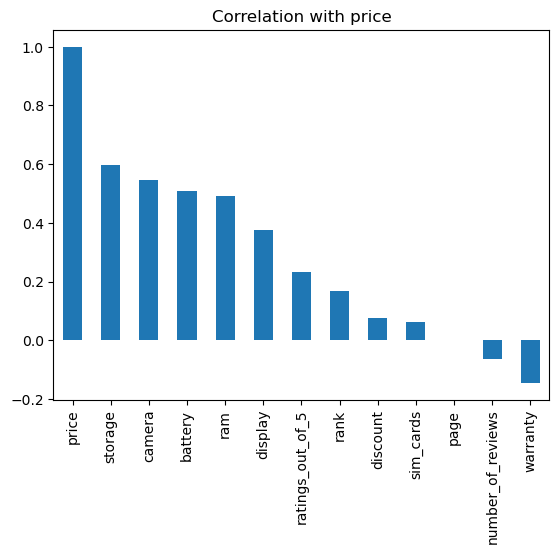

Linear Regression Coefficients for price:
             Feature  Coefficient
0   ratings_out_of_5  1900.861697
2                ram   557.327006
3               rank   121.178737
1             camera    94.220692
4  number_of_reviews     4.278102
Correlation with rank:
rank                 1.000000e+00
price                1.665352e-01
discount             1.454918e-01
page                -3.211122e-15
ratings_out_of_5    -2.403557e-02
storage             -2.752164e-02
ram                 -4.934622e-02
battery             -9.803317e-02
display             -1.551242e-01
camera              -1.864311e-01
warranty            -2.124909e-01
sim_cards           -2.572814e-01
number_of_reviews   -5.725927e-01
Name: rank, dtype: float64


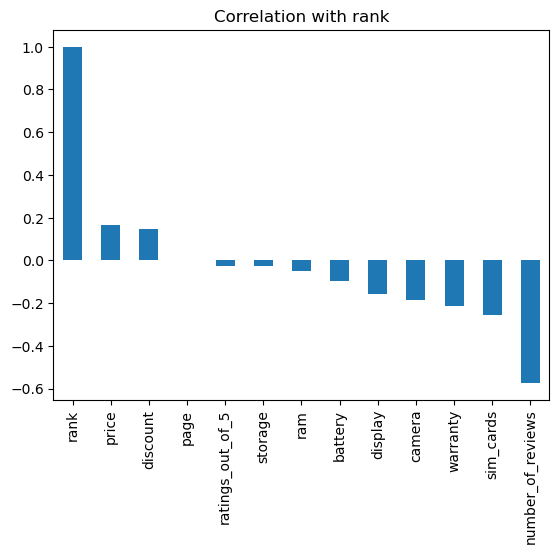

Linear Regression Coefficients for rank:
             Feature  Coefficient
0              price     0.000801
4  number_of_reviews    -0.068290
2             camera    -0.121992
3                ram    -0.239806
1   ratings_out_of_5    -7.552519


In [264]:
# Import linear regression
from sklearn.linear_model import LinearRegression


# Function to display correlation with a specific target and plot the correlation bar chart
def check_and_plot_correlation(target, df):
    correlation = df.corr()[target].sort_values(ascending=False)
    print(f"Correlation with {target}:")
    print(correlation)
    
    # Visualize the correlation as a bar plot
    correlation.plot(kind='bar')
    plt.title(f"Correlation with {target}")
    plt.show()

# Check correlations with 'ratings_out_of_5'
check_and_plot_correlation('ratings_out_of_5', numerical_df)

# Linear regression to model 'ratings_out_of_5' based on other features
X = final_df[['price', 'camera', 'ram', 'rank', 'number_of_reviews']]
y = final_df['ratings_out_of_5']
model = LinearRegression()
model.fit(X, y)

# Get and display the coefficients of the features
feature_coefficients = model.coef_
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print("Linear Regression Coefficients for ratings_out_of_5:")
print(coeff_df)

# Check correlations with 'price'
check_and_plot_correlation('price', numerical_df)

# Linear regression to model 'price' based on other features
X = final_df[['ratings_out_of_5', 'camera', 'ram', 'rank', 'number_of_reviews']]
y = final_df['price']
model.fit(X, y)

# Get and display the coefficients of the features
feature_coefficients = model.coef_
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print("Linear Regression Coefficients for price:")
print(coeff_df)

# Check correlations with 'rank'
check_and_plot_correlation('rank', numerical_df)

# Linear regression to model 'rank' based on other features
X = final_df[['price', 'ratings_out_of_5', 'camera', 'ram', 'number_of_reviews']]
y = final_df['rank']
model.fit(X, y)

# Get and display the coefficients of the features
feature_coefficients = model.coef_
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print("Linear Regression Coefficients for rank:")
print(coeff_df)

## Key Insights:

From the output, we can conclude several important insights about the relationships between product features:

**Impact of Ratings on Price and Rank:** The analysis shows that ratings are a significant predictor for both price and rank. Higher ratings generally lead to higher prices and higher ranks. This suggests that consumers tend to associate better-rated products with higher quality, and sellers may price such products higher.

**RAM's Role:** RAM emerges as a key feature influencing both ratings and price. It has a positive relationship with both, meaning that products with more RAM tend to have higher ratings and are priced higher. This aligns with the idea that better performance (represented by higher RAM) is valued by consumers.

**Price Correlations:** Price correlates positively with features like battery, storage, and camera, which makes sense, as these are common indicators of premium product tiers. Interestingly, number of reviews has a slight negative correlation with price, suggesting that higher-priced products may have fewer reviews, possibly because they are less frequently purchased or newer to the market.

**Rank and Reviews:** Rank is negatively correlated with the number of reviews, meaning that products with fewer reviews tend to have higher ranks. This could indicate that top-ranked products might be newer or niche products that haven't accumulated as many reviews yet.

**Importance of Features in Predicting Price and Rank:** The regression models show that ratings have the strongest influence on price (with a very large coefficient), followed by RAM, rank, and camera. For rank, ratings again play a major role, followed by RAM and price. This highlights how consumer sentiment (ratings) and product features (such as performance and camera quality) drive product positioning in both rankings and pricing.

In summary, product features like ratings, RAM, camera, and rank strongly influence price and rank, with ratings emerging as the most important factor.

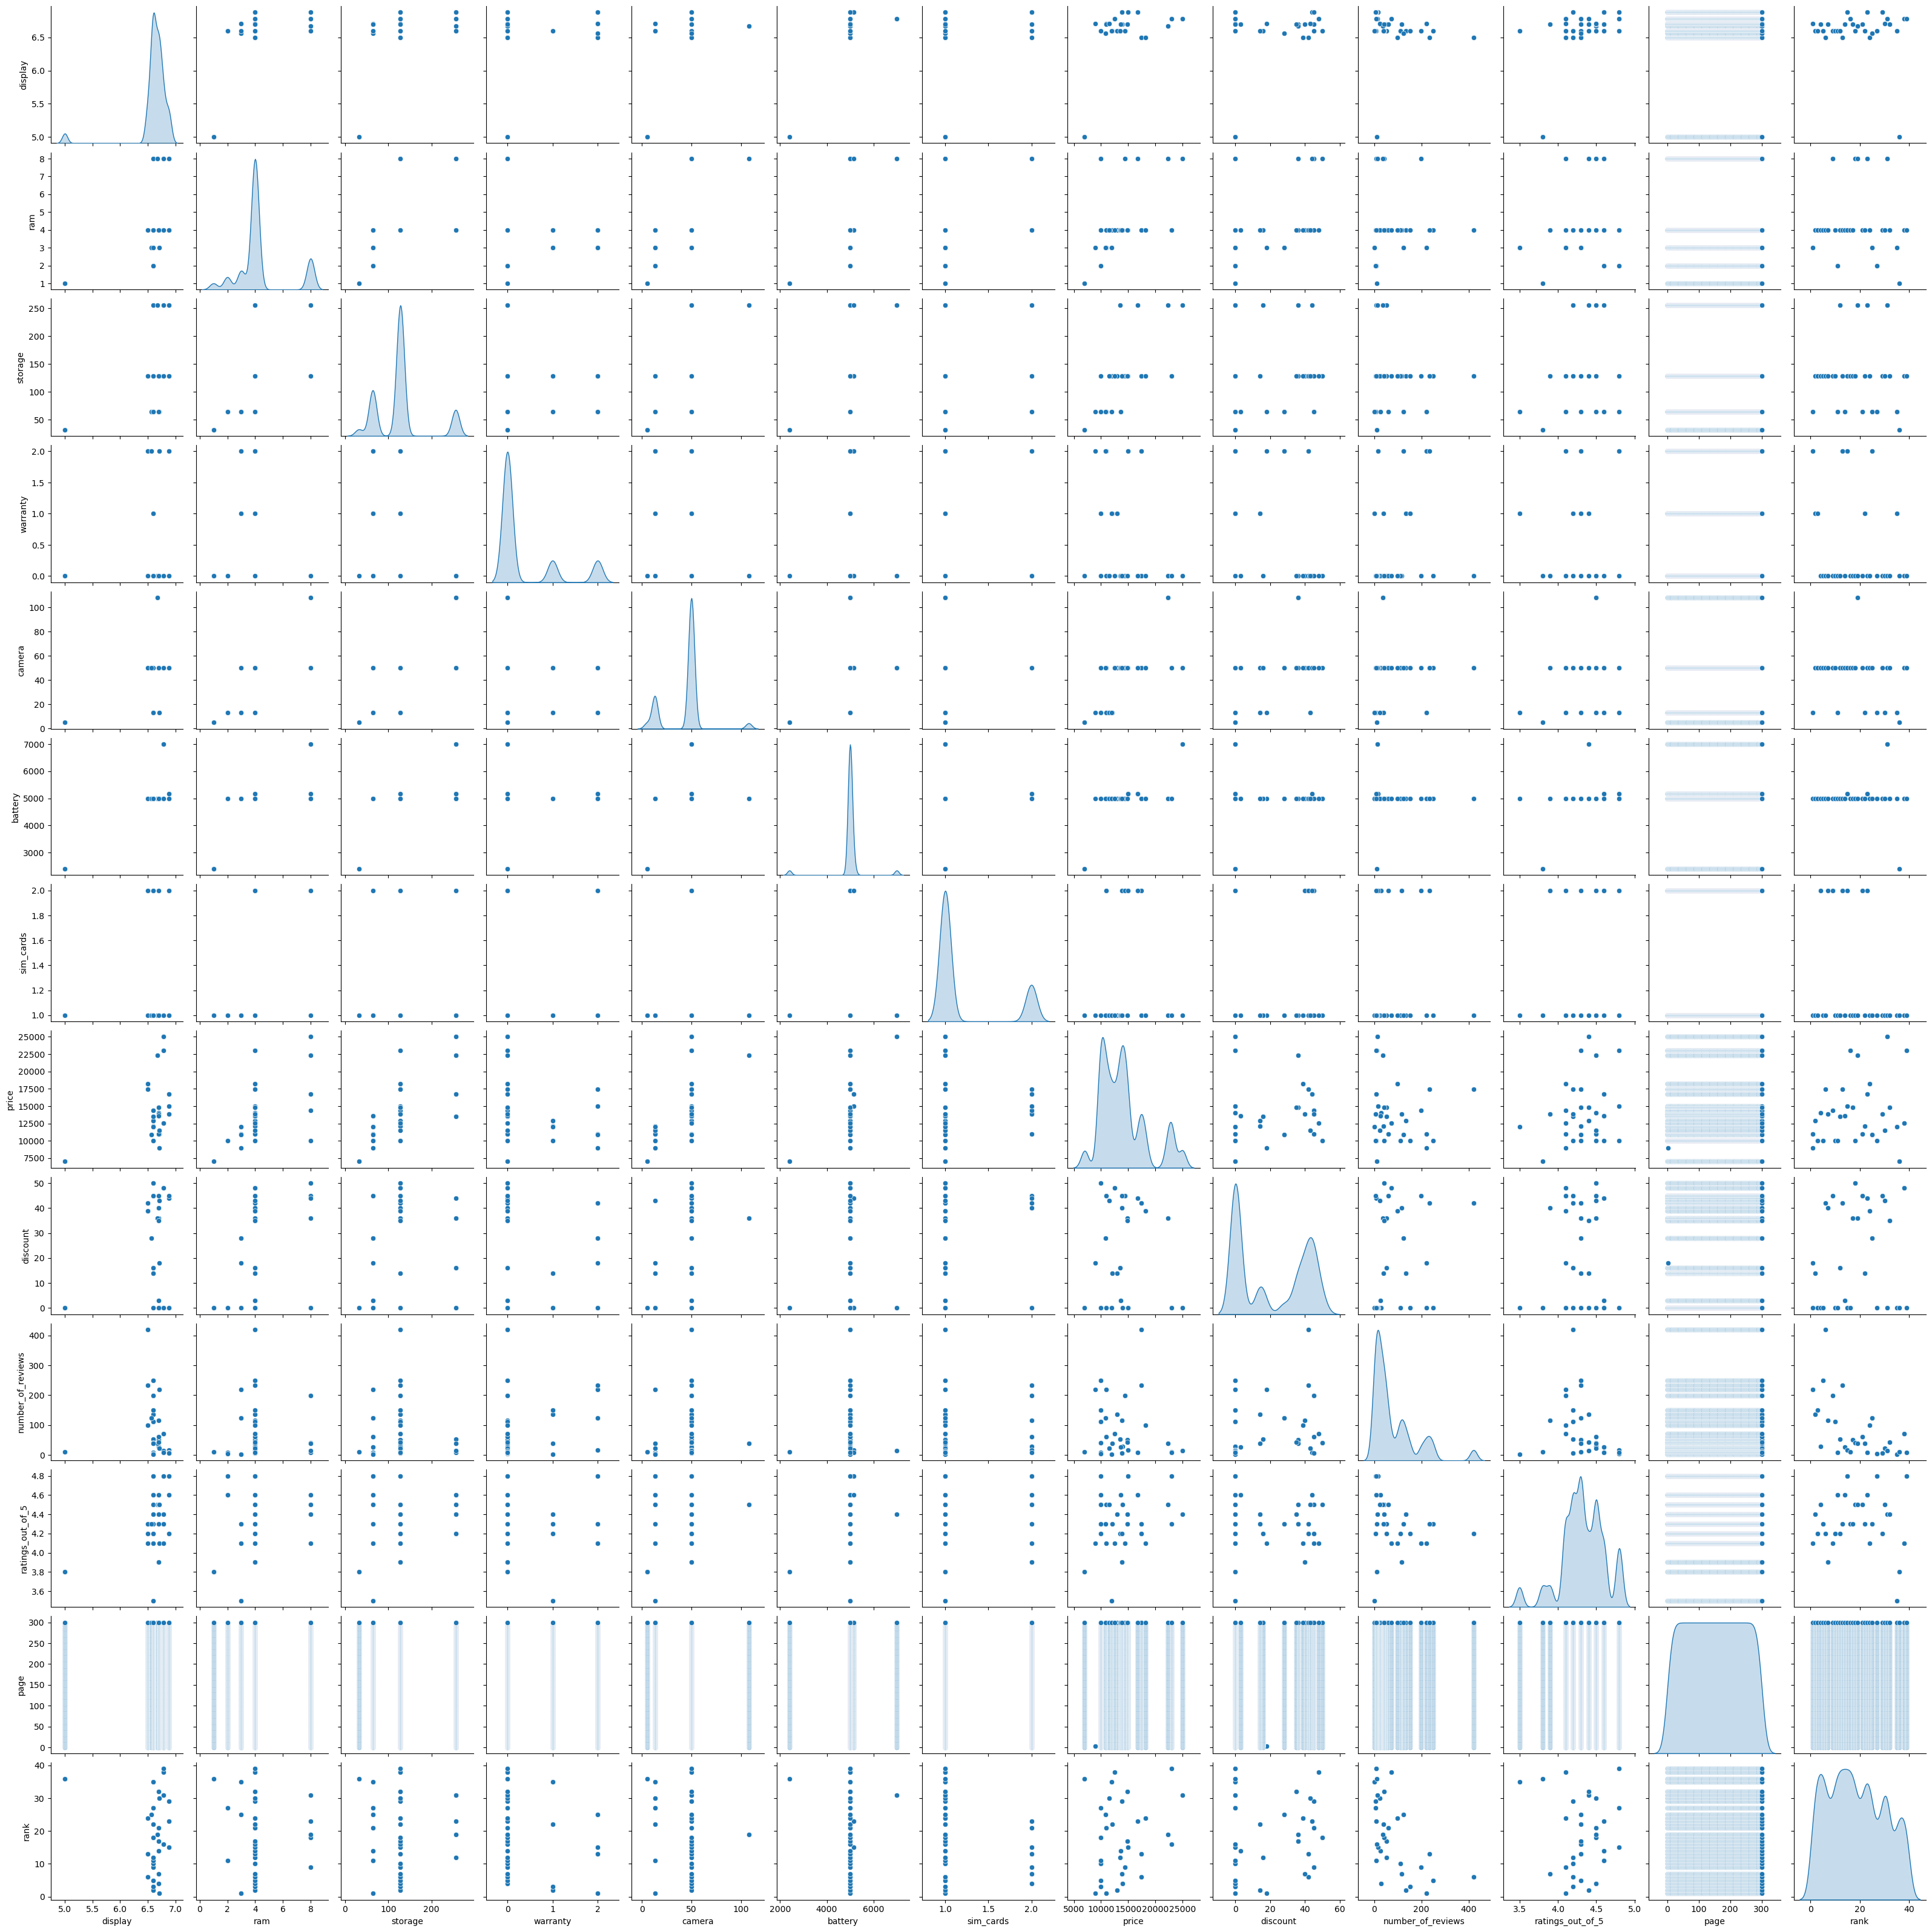

In [265]:
# Create a pair plot for the product features
sns.pairplot(numerical_df, diag_kind='kde')
plt.show()